In [1]:
from poisson_fem import PoissonFEM
import ROM
import GenerativeSurrogate as gs
import Data as dta
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as lg
import time
import petsc4py
import sys
petsc4py.init(sys.argv)
from petsc4py import PETSc
import torch

In [2]:
# Some fixed parameters
lin_dim_rom = 4                         # Linear number of rom elements
a = np.array([1, 2, 3])              # Boundary condition function coefficients
dim_z = 2                            # Latent space dimension

In [3]:
# Define mesh and boundary conditions
mesh = PoissonFEM.RectangularMesh(np.ones(lin_dim_rom)/lin_dim_rom)
# mesh.plot()

def origin(x):
    return np.abs(x[0]) < np.finfo(float).eps and np.abs(x[1]) < np.finfo(float).eps

def essBoundaryFun(x):
    return 0.0
mesh.setEssentialBoundary(origin, essBoundaryFun)

def domainBoundary(x):
    # unit square
    return np.abs(x[0]) < np.finfo(float).eps or np.abs(x[1]) < np.finfo(float).eps or \
            np.abs(x[0]) > 1.0 - np.finfo(float).eps or np.abs(x[1]) > 1.0 - np.finfo(float).eps
mesh.setNaturalBoundary(domainBoundary)

def flux(x):
    q = np.array([a[0] + a[2]*x[1], a[1] + a[2]*x[0]])
    return q

In [4]:
#Spepify right hand side and stiffness matrix
#Define boundary flux field
rhs = PoissonFEM.RightHandSide(mesh)
rhs.setNaturalRHS(mesh, flux)
funSpace = PoissonFEM.FunctionSpace(mesh)
K = PoissonFEM.StiffnessMatrix(mesh, funSpace)
rhs.setRhsStencil(mesh, K)

In [5]:
# Set up solver
ksp = PETSc.KSP().create()
ksp.setType('preonly')
precond = ksp.getPC()
precond.setType('cholesky')
ksp.setFromOptions() #???

In [6]:
# define rom
rom = ROM.ROM(mesh, K, rhs, ksp)

In [7]:
# Test rom -- this can be removed
# Effective diffusivities -- this should come from pc

# lmbda = PETSc.Vec().createSeq(mesh.nCells)
# lmbda.setValues(range(mesh.nCells), np.arange(5.0, rom_dim**2 + 5.0))
# rom.solve(lmbda)
# print('solution = ', rom.solution.array)

In [8]:
pc = gs.Pc(dim_z, rom.mesh.nCells)
model = gs.GenerativeSurrogate(rom, pc, dim_z)

z = model.pz.sample()
lmbda = PETSc.Vec().createSeq(model.rom.mesh.nCells)
lmbda.setValues(model.rom.stiffnessMatrix.rangeCells, model.pc(z).detach().numpy())
model.rom.solve(lmbda)

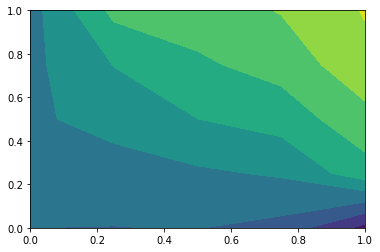

In [9]:
# model.rom.solution.array
rom.plotSolution()

In [10]:
trainingData = dta.StokesData([2, 5, 12])

In [11]:
trainingData.readData(['X', 'P', 'V', 'M'])

In [12]:
trainingData.input2bitmap()

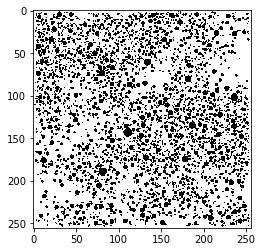

In [13]:
trainingData.plotMicrostruct(1)

In [14]:
pf = gs.Pf(dim_z, 128)